In [4]:
# ==============================================================================
# 1. SETUP AND IMPORTS
# ==============================================================================
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

print("TensorFlow Version:", tf.__version__)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow Version: 2.18.0


In [5]:
# ==============================================================================
# 2. CONFIGURATION
# ==============================================================================
# File paths in Google Drive
BASE_PATH = '/content/drive/My Drive/Colab Notebooks/quora_spam_detection/'
TRAIN_DATA_FILE = os.path.join(BASE_PATH, 'train.csv')
GLOVE_EMBEDDING_FILE = os.path.join(BASE_PATH, 'glove.6B.100d.txt')

# Model and Tokenizer parameters
MAX_NUM_WORDS = 20000      # Max vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Max length for a question
EMBEDDING_DIM = 100        # Dimension of GloVe embeddings (must match the file)
VALIDATION_SPLIT = 0.2     # 20% of data for validation
BATCH_SIZE = 256
EPOCHS = 10

In [6]:
# ==============================================================================
# 3. DATA LOADING AND PREPROCESSING
# ==============================================================================
print("\nLoading and preprocessing data...")

# Load the training data
df = pd.read_csv(TRAIN_DATA_FILE)

print(f"Loaded {len(df)} questions.")
print("Sample of the data:")
print(df.head())
print("\nClass distribution:")
print(df['target'].value_counts(normalize=True))


Loading and preprocessing data...
Loaded 1306122 questions.
Sample of the data:
                    qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

Class distribution:
target
0    0.93813
1    0.06187
Name: proportion, dtype: float64


In [7]:

# Clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text) # Keep only alphanumeric and spaces
    return text

df['question_text'] = df['question_text'].apply(clean_text)



In [8]:
# Prepare texts and labels
texts = df['question_text'].values
labels = df['target'].values

# Tokenize the text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Pad sequences to a fixed length
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print("Shape of data tensor:", data.shape)
print("Shape of labels tensor:", labels.shape)



Found 247247 unique tokens.
Shape of data tensor: (1306122, 100)
Shape of labels tensor: (1306122,)


In [9]:
# ==============================================================================
# 4. PREPARE GLOVE EMBEDDING MATRIX
# ==============================================================================
print("\nLoading GloVe embeddings and building embedding matrix...")

embeddings_index = {}
try:
    with open(GLOVE_EMBEDDING_FILE, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print(f"Error: GloVe file not found at {GLOVE_EMBEDDING_FILE}")
    print("Please ensure the file path is correct and you have mounted Google Drive.")
    # Exit gracefully if file is not found
    exit()


print(f"Found {len(embeddings_index)} word vectors in GloVe.")

# Create the embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix created with shape: {embedding_matrix.shape}")




Loading GloVe embeddings and building embedding matrix...
Found 400000 word vectors in GloVe.
Embedding matrix created with shape: (20000, 100)


In [10]:
# ==============================================================================
# 5. CREATE TRAIN/VALIDATION SPLIT
# ==============================================================================
# As per guidelines, create our own split
X_train, X_val, y_train, y_val = train_test_split(
    data,
    labels,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=labels # Ensure same class distribution in train and val sets
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")




Training data shape: (1044897, 100)
Validation data shape: (261225, 100)


In [11]:
# ==============================================================================
# 6. BUILD THE DEEP LEARNING MODEL
# ==============================================================================
print("\nBuilding the model...")

# Input layer
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Embedding layer
# We use our pre-trained GloVe embeddings and make them non-trainable
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)(input_layer)

# Bidirectional LSTM layer
# This helps the model learn from the sequence in both forward and backward directions
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
lstm_layer = Bidirectional(LSTM(64))(lstm_layer) # Another layer for more complexity

# Dense layers for classification
dense_layer = Dense(64, activation='relu')(lstm_layer)
dense_layer = Dropout(0.5)(dense_layer) # Dropout for regularization
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
model.summary()




Building the model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,407,169 (9.18 MB)

 Trainable params: 407,169 (1.55 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [12]:
# ==============================================================================
# 7. TRAIN THE MODEL
# ==============================================================================
print("\nTraining the model...")

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)




Training the model...
Epoch 1/10
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 199s 47ms/step - accuracy: 0.9463 - loss: 0.1494 - val_accuracy: 0.9544 - val_loss: 0.1186
Epoch 2/10
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 197s 48ms/step - accuracy: 0.9553 - loss: 0.1158 - val_accuracy: 0.9564 - val_loss: 0.1100
Epoch 3/10
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 200s 48ms/step - accuracy: 0.9579 - loss: 0.1081 - val_accuracy: 0.9581 - val_loss: 0.1072
Epoch 4/10
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 196s 48ms/step - accuracy: 0.9598 - loss: 0.1027 - val_accuracy: 0.9584 - val_loss: 0.1069
Epoch 5/10
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 203s 48ms/step - accuracy: 0.9613 - loss: 0.0971 - val_accuracy: 0.9584 - val_loss: 0.1076
Epoch 6/10
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 202s 48ms/step - accuracy: 0.9635 - loss: 0.0912 - val_accuracy: 0.9568 - val_loss: 0.1101



Evaluating the model on the validation set...
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 61s 7ms/step

Validation Accuracy: 0.9584

Classification Report:
               precision    recall  f1-score   support

  Sincere (0)       0.97      0.98      0.98    245063
Insincere (1)       0.69      0.60      0.64     16162

     accuracy                           0.96    261225
    macro avg       0.83      0.79      0.81    261225
 weighted avg       0.96      0.96      0.96    261225



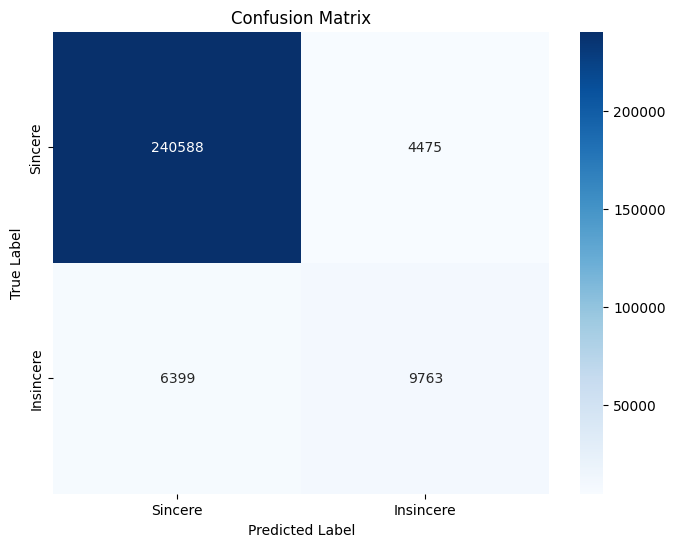

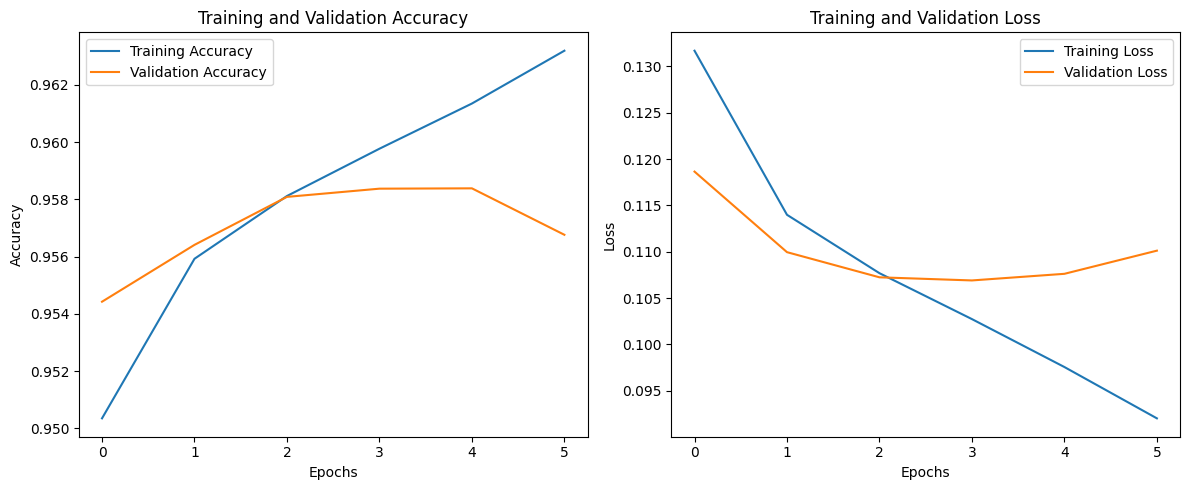

In [13]:
# ==============================================================================
# 8. EVALUATE THE MODEL
# ==============================================================================
print("\nEvaluating the model on the validation set...")

# Get predictions (as probabilities)
y_pred_prob = model.predict(X_val)
# Convert probabilities to binary classes (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate and print metrics
accuracy = accuracy_score(y_val, y_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Sincere (0)', 'Insincere (1)']))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sincere', 'Insincere'],
            yticklabels=['Sincere', 'Insincere'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)



In [24]:
# ==============================================================================
# 9. INFERENCE ON NEW QUESTIONS
# ==============================================================================
def predict_insincerity(question, model, tokenizer, max_len):
    """Predicts if a single question is insincere."""
    # Preprocess the new question
    cleaned_question = clean_text(question)
    sequence = tokenizer.texts_to_sequences([cleaned_question])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Make a prediction
    prediction = model.predict(padded_sequence, verbose=0)[0][0]

    # Interpret the result
    if prediction > 0.5:
        return f"Insincere (Spam) - Confidence: {prediction:.2%}"
    else:
        return f"Sincere - Confidence: {1-prediction:.2%}"

# Example usage
print("\n--- Testing with new questions ---")
sincere_question = "What is the best way to learn Python for data science?"
sincere_question2 = "How macro economic conditions affect micro economics?"
insincere_question = "Why are all politicians liars and how can we stop them?"
insincere_question2 = "What are the best arguments to prove that the Earth is flat and that NASA is lying to everyone?"

print(f"Question: '{sincere_question}'")
print(f"Prediction: {predict_insincerity(sincere_question, model, tokenizer, MAX_SEQUENCE_LENGTH)}")
print("-" * 20)
print(f"Question: '{sincere_question2}'")
print(f"Prediction: {predict_insincerity(sincere_question2, model, tokenizer, MAX_SEQUENCE_LENGTH)}")
print("-" * 20)
print(f"Question: '{insincere_question}'")
print(f"Prediction: {predict_insincerity(insincere_question, model, tokenizer, MAX_SEQUENCE_LENGTH)}")
print("-" * 20)
print(f"Question: '{insincere_question2}'")
print(f"Prediction: {predict_insincerity(insincere_question2, model, tokenizer, MAX_SEQUENCE_LENGTH)}")



--- Testing with new questions ---
Question: 'What is the best way to learn Python for data science?'
Prediction: Sincere - Confidence: 100.00%
--------------------
Question: 'How macro economic conditions affect micro economics?'
Prediction: Sincere - Confidence: 100.00%
--------------------
Question: 'Why are all politicians liars and how can we stop them?'
Prediction: Insincere (Spam) - Confidence: 73.30%
--------------------
Question: 'What are the best arguments to prove that the Earth is flat and that NASA is lying to everyone?'
Prediction: Insincere (Spam) - Confidence: 56.85%


The previous cell failed to mount Google Drive. Let's try mounting it again in this cell. If this cell also fails, please ensure you are logged into your Google account and have granted Colab the necessary permissions to access your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')